In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display

import time
import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [4]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


#### Предварительная проверка файлов на соответствие размеру окна

In [5]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [8]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [9]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [10]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

____________

In [11]:
filenames = tf.random.shuffle(filenames_filtered)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [12]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900: 18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Validation set size 5400
Test set size 2700


In [13]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [14]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [15]:
def get_spectrogram(waveform):
    
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.mdct(waveform, frame_length=NFFT, pad_end=True)

    return spectrogram

In [16]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

In [17]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [18]:
def preprocess_dataset(files,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [19]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
num_frame = [1,3,5,10,15,20]

print('Количество вариантов num_frame', len(num_frame))

Количество вариантов num_frame 6


In [30]:
spectrs = [preprocess_dataset(train_files,num_frame[k]) for k in range(len(num_frame))]

train_=spectrs
val_ = [preprocess_dataset(val_files,num_frame[k]) for k in range(len(num_frame))]
test_ = [preprocess_dataset(test_files,num_frame[k]) for k in range(len(num_frame))]
len(spectrs)

6

In [31]:
batch_size = 64

train_ = [t.batch(batch_size) for t in train_]
val_ = [v.batch(batch_size) for v in val_]
train_ = [t.cache().prefetch(AUTOTUNE) for t in train_]
val_ = [v.cache().prefetch(AUTOTUNE) for v in val_]


test_audio_ = []
test_labels_ = []

for t_ds in test_:
    test_audio = []
    test_labels = []
    for audio, label in t_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    test_audio_.append(test_audio)
    test_labels_.append(test_labels)

input_shapes = []    
for s_ds in spectrs:
    for spectrogram, _ in s_ds.take(1):
        input_shapes.append(spectrogram.shape)
print(input_shapes)

[TensorShape([1, 4096]), TensorShape([3, 4096]), TensorShape([5, 4096]), TensorShape([10, 4096]), TensorShape([15, 4096]), TensorShape([20, 4096])]


In [43]:
import time
EPOCHS = 300
models = []
histories = []

Epoch 1/100
296/296 [==============================] - 10s 34ms/step - loss: 0.9954 - accuracy: 0.7773 - val_loss: 0.7175 - val_accuracy: 0.8380
Epoch 2/100
296/296 [==============================] - 10s 33ms/step - loss: 0.2724 - accuracy: 0.9406 - val_loss: 0.7493 - val_accuracy: 0.8633
Epoch 3/100
296/296 [==============================] - 10s 33ms/step - loss: 0.2164 - accuracy: 0.9595 - val_loss: 0.8788 - val_accuracy: 0.8609
Epoch 4/100
296/296 [==============================] - 10s 33ms/step - loss: 0.2378 - accuracy: 0.9538 - val_loss: 0.9784 - val_accuracy: 0.8669
Epoch 5/100
296/296 [==============================] - 10s 34ms/step - loss: 0.1656 - accuracy: 0.9695 - val_loss: 1.0028 - val_accuracy: 0.8783
Epoch 6/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1663 - accuracy: 0.9727 - val_loss: 1.1275 - val_accuracy: 0.8665
Epoch 7/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1537 - accuracy: 0.9753 - val_loss: 1.1161 - val_ac

296/296 [==============================] - 10s 33ms/step - loss: 0.0944 - accuracy: 0.9953 - val_loss: 5.7757 - val_accuracy: 0.8806
Epoch 58/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1045 - accuracy: 0.9952 - val_loss: 4.8549 - val_accuracy: 0.8743
Epoch 59/100
296/296 [==============================] - 10s 34ms/step - loss: 0.0700 - accuracy: 0.9960 - val_loss: 4.6820 - val_accuracy: 0.8800
Epoch 60/100
296/296 [==============================] - 10s 33ms/step - loss: 0.0471 - accuracy: 0.9970 - val_loss: 5.0082 - val_accuracy: 0.8778
Epoch 61/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1475 - accuracy: 0.9930 - val_loss: 6.1562 - val_accuracy: 0.8772
Epoch 62/100
296/296 [==============================] - 10s 33ms/step - loss: 0.0784 - accuracy: 0.9953 - val_loss: 7.0736 - val_accuracy: 0.8717
Epoch 63/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1273 - accuracy: 0.9946 - val_loss: 6.0877 - val_accuracy

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

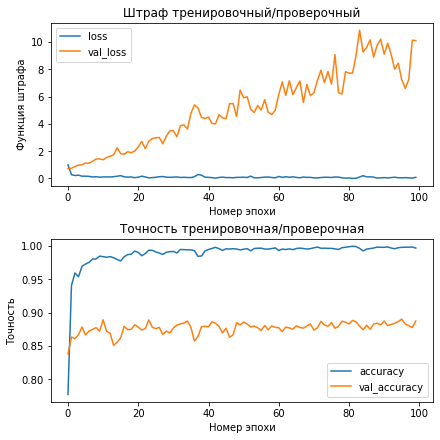

In [26]:
from datetime import datetime

k = 0
mymodel = create_model(input_shapes[k])

start_time = time.time()
myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
y_true = test_labels_[k]
test_acc = sum(y_pred == y_true) / len(y_true) * 100

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

Epoch 1/100
296/296 [==============================] - 10s 33ms/step - loss: 1.0212 - accuracy: 0.7761 - val_loss: 0.5817 - val_accuracy: 0.8676
Epoch 2/100
296/296 [==============================] - 10s 33ms/step - loss: 0.2818 - accuracy: 0.9398 - val_loss: 0.7393 - val_accuracy: 0.8611
Epoch 3/100
296/296 [==============================] - 10s 34ms/step - loss: 0.2099 - accuracy: 0.9557 - val_loss: 0.9787 - val_accuracy: 0.8478
Epoch 4/100
296/296 [==============================] - 10s 33ms/step - loss: 0.2250 - accuracy: 0.9554 - val_loss: 0.9991 - val_accuracy: 0.8641
Epoch 5/100
296/296 [==============================] - 10s 34ms/step - loss: 0.1805 - accuracy: 0.9665 - val_loss: 1.0410 - val_accuracy: 0.8685
Epoch 6/100
296/296 [==============================] - 10s 33ms/step - loss: 0.1274 - accuracy: 0.9759 - val_loss: 1.0408 - val_accuracy: 0.8770
--- 0.0 минут 59.2939989566803 секунд ---
85/85 [==============================] - 0s 5ms/step


[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

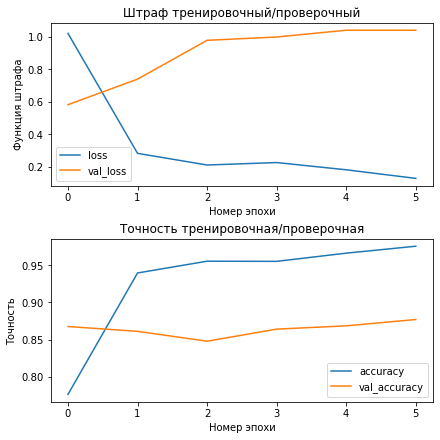

In [28]:
k = 0
mymodel = create_model(input_shapes[k])

start_time = time.time()
myhistory = mymodel.fit(train_[k], validation_data=val_[k], 
                        epochs=EPOCHS, verbose=1, 
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
y_true = test_labels_[k]
test_acc = sum(y_pred == y_true) / len(y_true) * 100

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [44]:
tests_acc = []
for k in range(len(num_frame)):
    print('---------------------------------------------------------------------')
    print('Количество спектрограмм: ',num_frame[k])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    
    print('Количество спектрограмм: ',num_frame[k], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)
    

---------------------------------------------------------------------
Количество спектрограмм:  1
2022-06-08 12:08:18
--- 0.0 минут 33.67310452461243 секунд ---
85/85 [==============================] - 0s 2ms/step
Количество спектрограмм:  1 , accuracy тестовой выборки:  78.92592592592592 %
---------------------------------------------------------------------
Количество спектрограмм:  3
2022-06-08 12:08:52
--- 1.0 минут 7.376557111740112 секунд ---
85/85 [==============================] - 0s 4ms/step
Количество спектрограмм:  3 , accuracy тестовой выборки:  88.66666666666667 %
---------------------------------------------------------------------
Количество спектрограмм:  5
2022-06-08 12:10:00
--- 1.0 минут 48.44133400917053 секунд ---
85/85 [==============================] - 0s 5ms/step
Количество спектрограмм:  5 , accuracy тестовой выборки:  87.18518518518519 %
---------------------------------------------------------------------
Количество спектрограмм:  10
2022-06-08 12:11:49
--- 3

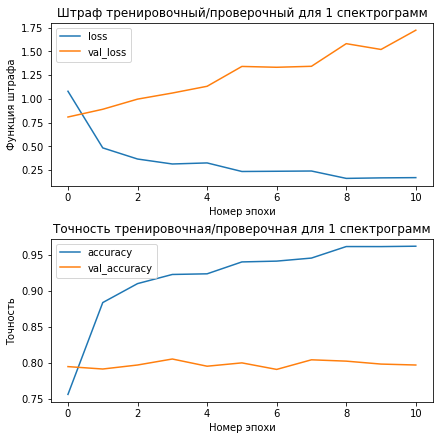

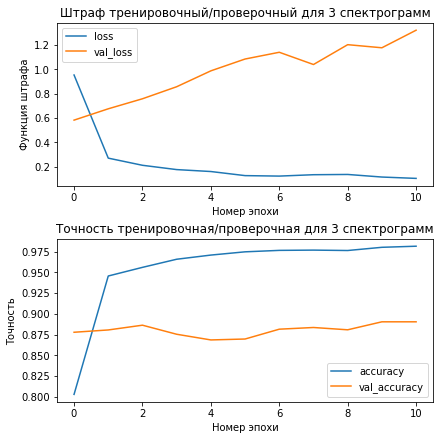

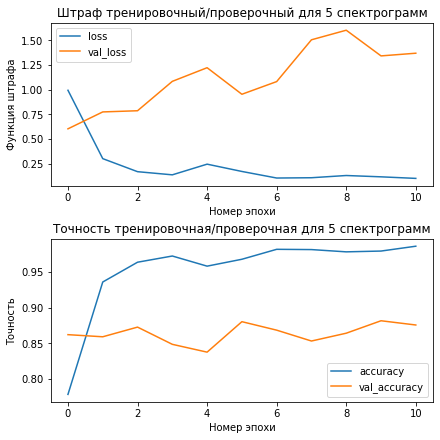

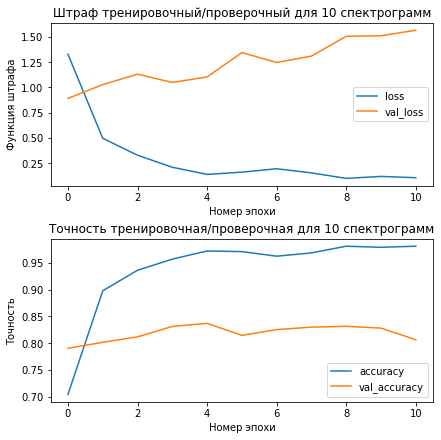

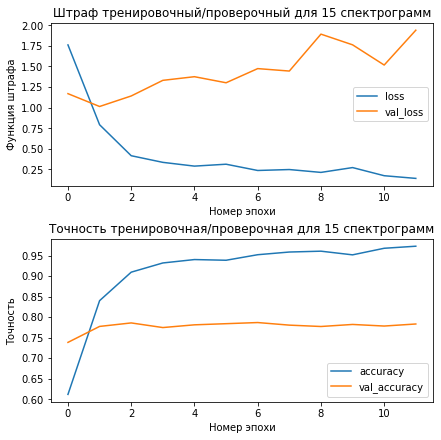

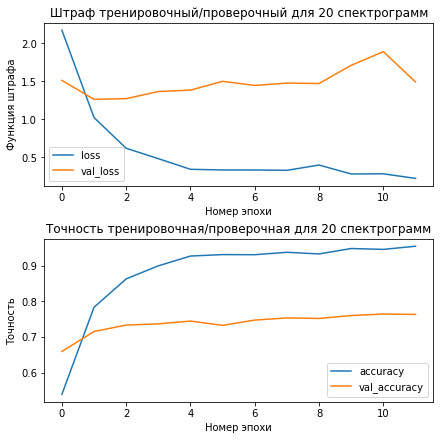

In [45]:
for k in range(len(num_frame)):

    metrics = histories[k].history
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
    axes[0].plot(histories[k].epoch, metrics['loss'], metrics['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k]} спектрограмм')

    axes[1].plot(histories[k].epoch, metrics['accuracy'], metrics['val_accuracy'])
    axes[1].legend(['accuracy', 'val_accuracy'])
    axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k]} спектрограмм')

Text(0.5, 1.0, 'Зависимость точности от количества спектрограмм')

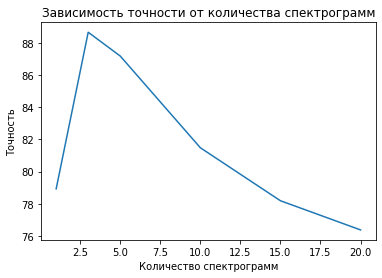

In [46]:
plt.plot(num_frame,tests_acc)
plt.xlabel('Количество спектрограмм')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества спектрограмм')

In [47]:
res = np.array([(num_frame[k], tests_acc[k]) for k in range(len(num_frame))])
res

array([[ 1.        , 78.92592593],
       [ 3.        , 88.66666667],
       [ 5.        , 87.18518519],
       [10.        , 81.48148148],
       [15.        , 78.18518519],
       [20.        , 76.37037037]])

In [48]:
k_max = np.argmax(np.array(tests_acc))
k_max

1

In [49]:
print('Лучшее количество спектрограмм: ', num_frame[k_max])

Лучшее количество спектрограмм:  3


In [54]:
test_audio = test_audio_[k_max]
test_labels = test_labels_[k_max]

test_acc = tests_acc[k_max]
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels

85/85 [==============================] - 0s 4ms/step


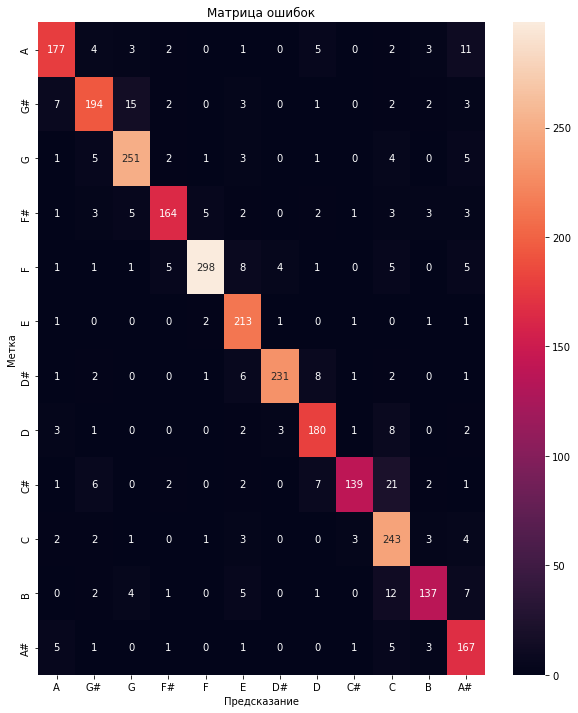

In [55]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


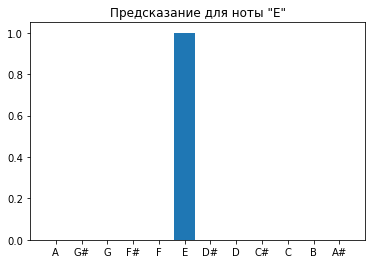

1


In [56]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],num_frame[k_max])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [58]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_mdct.h5")

C:\Users\belas\AppData\Local\Temp/ipykernel_13140/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


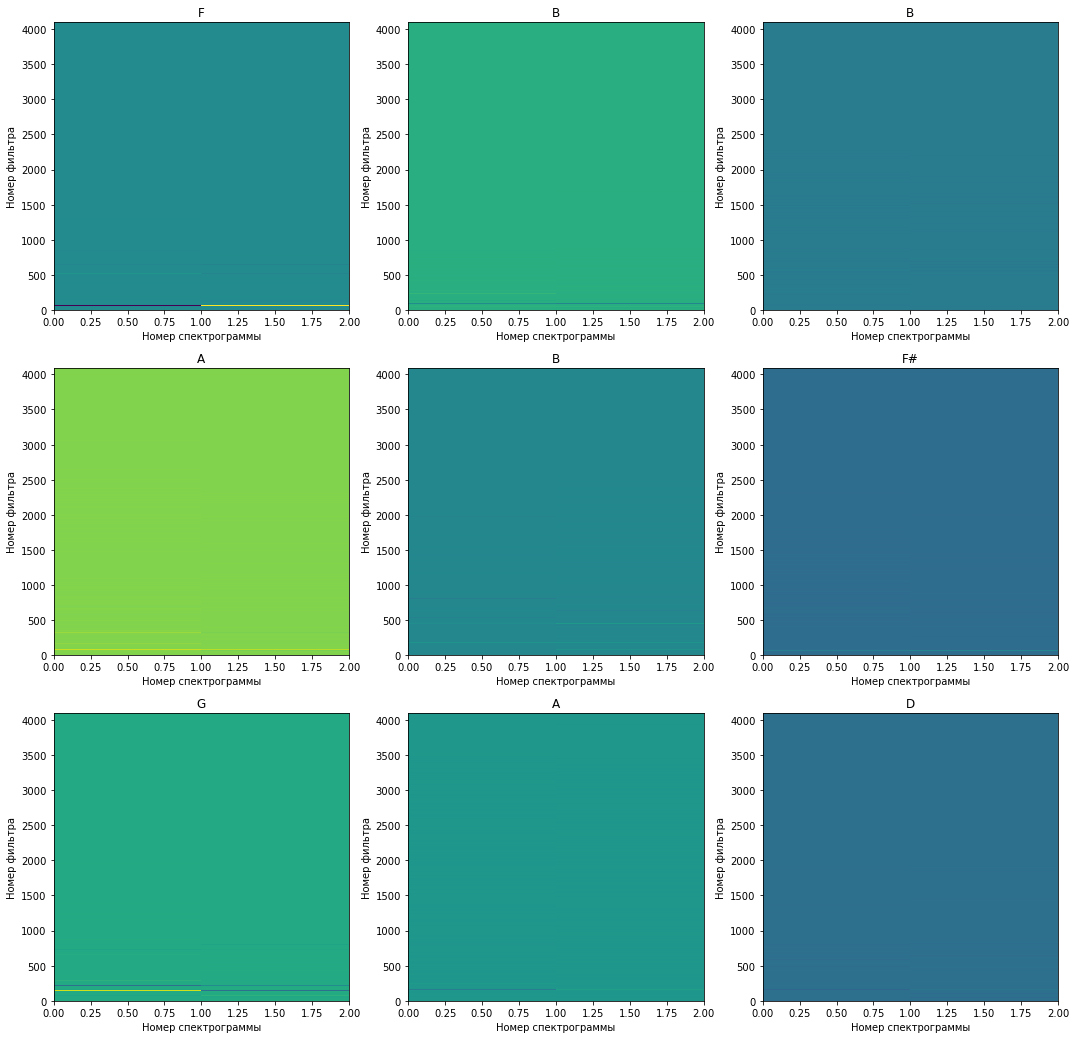

In [59]:
spectrogram_ds = spectrs[k_max]

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()

Видно, что спектрограммы практически не несут никакой информации.

In [61]:
model_.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 3, 4096)]         0         
                                                                 
 flatten_23 (Flatten)        (None, 12288)             0         
                                                                 
 relu_1 (Dense)              (None, 512)               6291968   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 6,823,436
Trainable params: 6,823,436
Non-tr

Пробуем увеличить количество эпох для 3 спектрограмм.

In [63]:
print('---------------------------------------------------------------------')
print('Количество спектрограмм: ',num_frame[k_max])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shapes[k_max])

start_time = time.time()
myhistory = mymodel.fit(train_[k_max], validation_data=val_[k_max], epochs=50, verbose=0)
                        #callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k_max]), axis=1)
y_true = test_labels_[k_max]
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Количество спектрограмм: ',num_frame[k], ', accuracy тестовой выборки: ', test_acc, '%')

---------------------------------------------------------------------
Количество спектрограмм:  3
2022-06-08 12:45:26
--- 5.0 минут 31.795092344284058 секунд ---
85/85 [==============================] - 0s 5ms/step
Количество спектрограмм:  20 , accuracy тестовой выборки:  88.77777777777777 %


[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для 3 спектрограмм на 50 эпохах')]

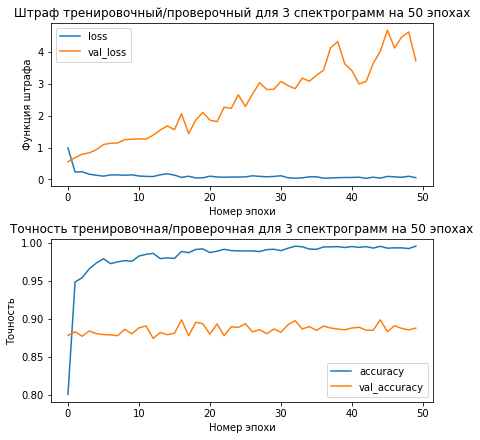

In [64]:
metrics = myhistory.history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k_max]} спектрограмм на 50 эпохах')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k_max]} спектрограмм на 50 эпохах')